In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp drive/MyDrive/Datasets/datasets.zip .

In [5]:
!unzip datasets.zip

Streaming output truncated to the last 5000 lines.
  inflating: datasets/natural_images/cat/cat_0632.jpg  
  inflating: datasets/natural_images/cat/cat_0633.jpg  
  inflating: datasets/natural_images/cat/cat_0634.jpg  
  inflating: datasets/natural_images/cat/cat_0635.jpg  
  inflating: datasets/natural_images/cat/cat_0636.jpg  
  inflating: datasets/natural_images/cat/cat_0637.jpg  
  inflating: datasets/natural_images/cat/cat_0638.jpg  
  inflating: datasets/natural_images/cat/cat_0639.jpg  
  inflating: datasets/natural_images/cat/cat_0640.jpg  
  inflating: datasets/natural_images/cat/cat_0641.jpg  
  inflating: datasets/natural_images/cat/cat_0642.jpg  
  inflating: datasets/natural_images/cat/cat_0643.jpg  
  inflating: datasets/natural_images/cat/cat_0644.jpg  
  inflating: datasets/natural_images/cat/cat_0645.jpg  
  inflating: datasets/natural_images/cat/cat_0646.jpg  
  inflating: datasets/natural_images/cat/cat_0647.jpg  
  inflating: datasets/natural_images/cat/cat_0648.jpg

In [9]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms as T

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [11]:
# ImageNet Normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [12]:
train_transform = T.Compose([
                             T.RandomResizedCrop(224),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=mean, std=std)])

In [13]:
test_transform = T.Compose([
                            T.Resize(256),
                            T.CenterCrop(224),
                            T.ToTensor(),
                            T.Normalize(mean=mean, std=std)])

In [15]:
train_dir = 'datasets/cats_or_dogs/train'
test_dir = 'datasets/cats_or_dogs/test'
batch_size = 8
num_workers = 2

In [16]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)
train_data

Dataset ImageFolder
    Number of datapoints: 2002
    Root location: datasets/cats_or_dogs/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [17]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

In [18]:
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

In [21]:
test_data

Dataset ImageFolder
    Number of datapoints: 1012
    Root location: datasets/cats_or_dogs/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

In [20]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

In [22]:
total_batch_sizes = {
    'train': len(train_loader),
    'test': len(test_loader)
}
total_batch_sizes

{'test': 127, 'train': 251}

In [23]:
class_names = train_data.classes
print(class_names)

['cats', 'dogs']


In [24]:
def imshow(inp, title):

  inp = inp.cpu().numpy().transpose((1, 2, 0))
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)

  plt.figure(figsize=(12, 6))

  plt.imshow(inp)
  plt.title(title)
  plt.pause(5);

In [25]:
inputs, classes = next(iter(dataloaders['train']))

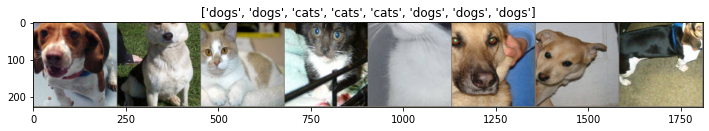

In [26]:
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [27]:
from torchvision import models

In [38]:
model = models.vgg16(pretrained=True)

In [39]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [41]:
model.classifier[6].out_features

1000

In [42]:
# Freeze all layer weights
for param in model.parameters():
  param.requires_grad = False

In [43]:
# Replace output layer with a new layer
model.classifier[6] = nn.Linear(num_ftrs, 2) # Only layer with requires_grad=True

In [44]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer_ft, step_size=7, gamma=0.1)

In [46]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  model = model.to(device)

  best_acc = 0.0
  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs + 1):

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print('=' * 10)

    for phase in ['train', 'test']:

      if phase == 'train':

        
        model.train()
      
      else:
        model.eval()
      
      running_loss, running_corrects = 0.0, 0

      for inputs, labels in dataloaders[phase]:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
            scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / total_batch_sizes[phase]
      epoch_acc = running_corrects.double() / (total_batch_sizes[phase] * batch_size)

      print(f'{phase} | loss: {epoch_loss:.4f} | acc: {epoch_acc:.4f}')

      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  print('Training Completed...')

  print(f'Best Val Acc: {best_acc:.4f}')

  model.load_state_dict(best_model_wts)

  return model         

In [47]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch [1/5]
train | loss: 2.3132 | acc: 0.8964
test | loss: 0.7758 | acc: 0.9675
Epoch [2/5]
train | loss: 2.3413 | acc: 0.9024
test | loss: 0.7758 | acc: 0.9675
Epoch [3/5]
train | loss: 2.0889 | acc: 0.9079
test | loss: 0.7758 | acc: 0.9675
Epoch [4/5]
train | loss: 2.1105 | acc: 0.9109
test | loss: 0.7758 | acc: 0.9675
Epoch [5/5]
train | loss: 1.8639 | acc: 0.9104
test | loss: 0.7758 | acc: 0.9675
Epoch [6/5]
train | loss: 2.1072 | acc: 0.9138
test | loss: 0.7758 | acc: 0.9675
Training Completed...
Best Val Acc: 0.9675


In [48]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
with torch.no_grad():
  correct = 0
  total = 0

  for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(f'Accuracy of the model on test images: {100*correct/total:.2f}')

Accuracy of the model on test images: 97.13


# Fine Tuning Top Layers
Using Oil Spill Dataset

In [50]:
train_transform = T.Compose([
                             T.RandomResizedCrop(224),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=mean, std=std)])

test_transform = T.Compose([
                            T.Resize(256),
                            T.CenterCrop(224),
                            T.ToTensor(),
                            T.Normalize(mean=mean, std=std)])

In [56]:
train_dir = 'datasets/Spill_Data/Train'
test_dir = 'datasets/Spill_Data/Test'
batch_size = 8
num_workers = 2

In [57]:
# The ImageNet dataset has many images of nature but none of oil spills in nature. So, it is best to fine-tune even the top layers

In [58]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [59]:
print(train_data, test_data)

Dataset ImageFolder
    Number of datapoints: 300
    Root location: datasets/Spill_Data/Train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) Dataset ImageFolder
    Number of datapoints: 112
    Root location: datasets/Spill_Data/Test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


Batch sizes: {'train': 38, 'test': 14}
CLasses: ['NoSpill', 'OilSpill']


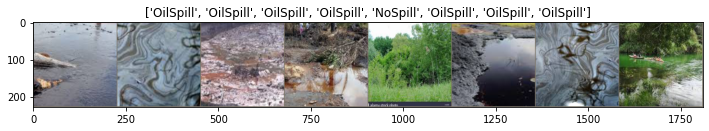

In [60]:
# Data Loading steps
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

total_batch_sizes = {
    'train': len(train_loader),
    'test': len(test_loader)
}
print(f'Batch sizes: {total_batch_sizes}')

class_names = train_data.classes
print(f'CLasses: {class_names}')

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [62]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [64]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [68]:
count = len(list(model.children()))
count

10

In [71]:
for i, child in enumerate(model.children()):
  if i + 1 < 7:
    for param in child.parameters():
      param.requires_grad = False # Freezing first 6 layers

In [72]:
model.fc = nn.Linear(num_ftrs, 2) # Create new output layer

In [73]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [75]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5) # The same train_model function works for this case as well

Epoch [1/5]
train | loss: 5.1256 | acc: 0.7632
test | loss: 3.5110 | acc: 0.8929
Epoch [2/5]
train | loss: 4.5834 | acc: 0.7434
test | loss: 2.7396 | acc: 0.8750
Epoch [3/5]
train | loss: 4.5867 | acc: 0.7928
test | loss: 2.7655 | acc: 0.9196
Epoch [4/5]
train | loss: 4.7451 | acc: 0.7664
test | loss: 3.1642 | acc: 0.9018
Epoch [5/5]
train | loss: 5.2446 | acc: 0.7796
test | loss: 3.1760 | acc: 0.8929
Epoch [6/5]
train | loss: 4.8256 | acc: 0.7862
test | loss: 2.6322 | acc: 0.8750
Training Completed...
Best Val Acc: 0.9196


In [76]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0

  for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(f'Accuracy of the model on test images: {100*correct/total:.2f}')

Accuracy of the model on test images: 91.96


# Reusing Model Architecture and Design


As the pneumonia X Ray dataset is very different from ImageNet, it is best to train the model from scratch.

Train Data: Dataset ImageFolder
    Number of datapoints: 5216
    Root location: datasets/chest_xray/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test Data: Dataset ImageFolder
    Number of datapoints: 624
    Root location: datasets/chest_xray/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Batch sizes: {'train': 1304, 'test': 156}
CLasses: ['NORMAL', 'PNEUMONIA']


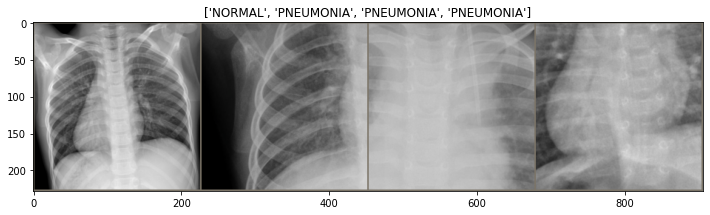

In [91]:
# Loading and Transforming data
train_transform = T.Compose([
                             T.RandomResizedCrop(224),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=mean, std=std)])

test_transform = T.Compose([
                            T.Resize(256),
                            T.CenterCrop(224),
                            T.ToTensor(),
                            T.Normalize(mean=mean, std=std)])

train_dir = 'datasets/chest_xray/train'
test_dir = 'datasets/chest_xray/test'
batch_size = 4
num_workers = 2

train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

print(f'Train Data: {train_data}')
print(f'Test Data: {test_data}')

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

total_batch_sizes = {
    'train': len(train_loader),
    'test': len(test_loader)
}
print(f'Batch sizes: {total_batch_sizes}')

class_names = train_data.classes
print(f'CLasses: {class_names}')

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [92]:
model = models.alexnet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [93]:
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, criterion, optimizer, num_epochs=25):

  model = model.to(device)
  total_step = len(dataloaders['train'])

  for epoch in range(num_epochs + 1):

    

    for i, (images, labels) in enumerate((dataloaders['train'])):

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      outputs = outputs.to(device)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] | Batch [{i + 1}/{total_step}] | Loss: {loss.item():.4f}')
  
  return model

In [95]:
model = train_model(model, criterion, optimizer_ft, num_epochs=10)
model.eval()
with torch.no_grad():
  correct = 0
  total = 0

  for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(f'Accuracy of the model on test images: {100*correct/total:.2f}')

Epoch [1/10] | Batch [100/1304] | Loss: 0.6877
Epoch [1/10] | Batch [200/1304] | Loss: 0.6881
Epoch [1/10] | Batch [300/1304] | Loss: 0.6925
Epoch [1/10] | Batch [400/1304] | Loss: 0.6847
Epoch [1/10] | Batch [500/1304] | Loss: 0.6905
Epoch [1/10] | Batch [600/1304] | Loss: 0.6931
Epoch [1/10] | Batch [700/1304] | Loss: 0.6922
Epoch [1/10] | Batch [800/1304] | Loss: 0.6879
Epoch [1/10] | Batch [900/1304] | Loss: 0.6847
Epoch [1/10] | Batch [1000/1304] | Loss: 0.6924
Epoch [1/10] | Batch [1100/1304] | Loss: 0.6885
Epoch [1/10] | Batch [1200/1304] | Loss: 0.6883
Epoch [1/10] | Batch [1300/1304] | Loss: 0.6889
Epoch [2/10] | Batch [100/1304] | Loss: 0.6886
Epoch [2/10] | Batch [200/1304] | Loss: 0.6891
Epoch [2/10] | Batch [300/1304] | Loss: 0.6887
Epoch [2/10] | Batch [400/1304] | Loss: 0.6891
Epoch [2/10] | Batch [500/1304] | Loss: 0.6863
Epoch [2/10] | Batch [600/1304] | Loss: 0.6888
Epoch [2/10] | Batch [700/1304] | Loss: 0.6907
Epoch [2/10] | Batch [800/1304] | Loss: 0.6945
Epoch [2/

# Fine-tuning the Network

Dataset Size: 6899
Train: 5519, Test: 1380
Batch sizes: {'train': 690, 'test': 173}
CLasses: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


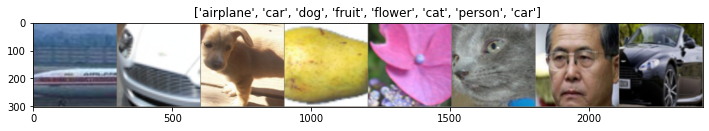

In [98]:
# Loading and Transforming data
transforms = T.Compose([
                             T.Resize(300),
                             T.RandomResizedCrop(299),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=mean, std=std)])


data_dir = 'datasets/natural_images'
batch_size = 8
num_workers = 2

dataset = datasets.ImageFolder(root=data_dir, transform=transforms)

print(f'Dataset Size: {len(dataset)}')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(f'Train: {train_size}, Test: {test_size}')

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

total_batch_sizes = {
    'train': len(train_loader),
    'test': len(test_loader)
}
print(f'Batch sizes: {total_batch_sizes}')

class_names = dataset.classes
print(f'CLasses: {class_names}')

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [99]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [100]:
model.classifier = nn.Linear(model.classifier.in_features, 8)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [101]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer_ft, step_size=7, gamma=0.1)

In [102]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  model = model.to(device)

  best_acc = 0.0
  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs + 1):

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print('=' * 10)

    for phase in ['train', 'test']:

      if phase == 'train':
        
        model.train()
      
      else:
        model.eval()
      
      running_loss, running_corrects = 0.0, 0

      for inputs, labels in dataloaders[phase]:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
            scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / total_batch_sizes[phase]
      epoch_acc = running_corrects.double() / (total_batch_sizes[phase] * batch_size)

      print(f'{phase} | loss: {epoch_loss:.4f} | acc: {epoch_acc:.4f}')

      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  print('Training Completed...')

  print(f'Best Val Acc: {best_acc:.4f}')

  model.load_state_dict(best_model_wts)

  return model         

In [103]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)
model.eval()
with torch.no_grad():
  correct = 0
  total = 0

  for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(f'Accuracy of the model on test images: {100*correct/total:.2f}')

Epoch [1/5]
train | loss: 10.2371 | acc: 0.5475
test | loss: 8.5006 | acc: 0.6366
Epoch [2/5]
train | loss: 10.1985 | acc: 0.5527
test | loss: 7.9559 | acc: 0.6705
Epoch [3/5]
train | loss: 10.0955 | acc: 0.5553
test | loss: 7.9545 | acc: 0.6684
Epoch [4/5]
train | loss: 10.2005 | acc: 0.5525
test | loss: 8.0567 | acc: 0.6655
Epoch [5/5]
train | loss: 10.2535 | acc: 0.5507
test | loss: 8.2180 | acc: 0.6712
Epoch [6/5]
train | loss: 10.0742 | acc: 0.5582
test | loss: 8.2952 | acc: 0.6525
Training Completed...
Best Val Acc: 0.6712
Accuracy of the model on test images: 64.71
